# Data Analysis (cavity_claw_RouteMeander_eigenmode)

## Configuration

Disable cell scrolling.

Parameters are stored in a shared script.

In [1]:
from parameters import *
os.makedirs('scalers', exist_ok=True)
os.makedirs(f'{DATA_DIR}', exist_ok=True)
os.makedirs(f'{DATA_DIR}/npy', exist_ok=True)

## Library

In [2]:
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
from sklearn.preprocessing import MinMaxScaler
import joblib

## Datasets

### Load

From https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/tree/main

In [3]:
import pandas as pd

df = pd.read_json("cavity_claw-RouteMeander-eigenmode.json")

### Look at the data and structure

In [4]:
#look at the first value
first_entry = df.iloc[100]

# Print the headers and their corresponding values
for header, value in first_entry.items():
    print(f"{header}: {value}")

sim_options: {'setup': {'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 50, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj': '0nH', 'Cj': '0fF'}, 'min_converged_passes': 2}, 'simulator': 'Ansys HFSS'}
sim_results: {'cavity_frequency': 5987186143.809999, 'kappa': 22053.7288176, 'units': 'Hz'}
design: {'design_options': {'claw_opts': {'connection_pads': {'readout': {'connector_location': '90', 'connector_type': '0', 'claw_length': '440um', 'ground_spacing': '4.1um', 'claw_gap': '5.1um', 'claw_width': '15um', 'claw_cpw_width': '11.7um', 'claw_cpw_length': '0um'}}, 'orientation': '-90', 'pos_x': '-1500um', 'cross_length': '0um', 'cross_width': '0um', 'cross_gap': '0um'}, 'cpw_opts': {'fillet': '49.9um', 'total_length': '3900um', 'trace_width': '11.7um', 'trace_gap': '5.1um', 'lead': {'start_straight': '50um'}, 'pin_inputs': {'start_pin': {'component': 'cplr', 

In [5]:
#Look at the headers relevant for us, to start lets only look at the sim_results (our x data) and design (our y data)
sim_results_column = df['sim_results']
print(sim_results_column, '\n\n')

design_column = df['design']
print(design_column)

0       {'cavity_frequency': 5353549772.64, 'kappa': 1...
1       {'cavity_frequency': 8399240836.29, 'kappa': 2...
2       {'cavity_frequency': 8694844797.89, 'kappa': 2...
3       {'cavity_frequency': 6616574393.559999, 'kappa...
4       {'cavity_frequency': 7986835171.7, 'kappa': 20...
                              ...                        
1211    {'cavity_frequency': 7489688801.09, 'kappa': 4...
1212    {'cavity_frequency': 7452442461.75, 'kappa': 3...
1213    {'cavity_frequency': 7415826341.76, 'kappa': 4...
1214    {'cavity_frequency': 7378752058.07, 'kappa': 4...
1215    {'cavity_frequency': 7342036181.17, 'kappa': 5...
Name: sim_results, Length: 1216, dtype: object 


0       {'design_options': {'claw_opts': {'connection_...
1       {'design_options': {'claw_opts': {'connection_...
2       {'design_options': {'claw_opts': {'connection_...
3       {'design_options': {'claw_opts': {'connection_...
4       {'design_options': {'claw_opts': {'connection_...
                      

In [6]:
#take a look at everything in the design dataset
#flatten what will be our y data
#Makes each row correspond to one element of df['design']
#If a particular row's dict doesn’t have that key, it fills in NaN
design_flat = json_normalize(df['design'])

# List all column headers
design_column_vals = design_flat.columns.tolist()
print(design_column_vals)
print('length: ',len(design_column_vals))

['coupler_type', 'resonator_type', 'design_tool', 'design_options.claw_opts.connection_pads.readout.connector_location', 'design_options.claw_opts.connection_pads.readout.connector_type', 'design_options.claw_opts.connection_pads.readout.claw_length', 'design_options.claw_opts.connection_pads.readout.ground_spacing', 'design_options.claw_opts.connection_pads.readout.claw_gap', 'design_options.claw_opts.connection_pads.readout.claw_width', 'design_options.claw_opts.connection_pads.readout.claw_cpw_width', 'design_options.claw_opts.connection_pads.readout.claw_cpw_length', 'design_options.claw_opts.orientation', 'design_options.claw_opts.pos_x', 'design_options.claw_opts.cross_length', 'design_options.claw_opts.cross_width', 'design_options.claw_opts.cross_gap', 'design_options.cpw_opts.fillet', 'design_options.cpw_opts.total_length', 'design_options.cpw_opts.trace_width', 'design_options.cpw_opts.trace_gap', 'design_options.cpw_opts.lead.start_straight', 'design_options.cpw_opts.pin_inp

In [7]:
# first n values from the column
for v in design_flat["design_options.cplr_opts.coupling_length"].iloc[500:510]:
    print(v)

230um
230um
nan
nan
nan
nan
nan
nan
nan
nan


### Reformat

In [8]:
#flatten what will be our X data
X = json_normalize(df['sim_results'])
# Dropping the 'units' column for now because i think they are al in Hz and this info isnt useful
X = X.drop(columns=['units'])
print(X)

      cavity_frequency          kappa
0         5.353550e+09  161106.598429
1         8.399241e+09  268412.116632
2         8.694845e+09  255873.654612
3         6.616574e+09   30459.761161
4         7.986835e+09  208304.221064
...                ...            ...
1211      7.489689e+09   46004.713078
1212      7.452442e+09   38837.211205
1213      7.415826e+09   46696.417529
1214      7.378752e+09   41526.048615
1215      7.342036e+09   58463.648381

[1216 rows x 2 columns]


In [9]:
#flatten what will be our y data
#Makes each row correspond to one element of df['design']
#If a particular row's dict doesn’t have that key, it fills in NaN
y = json_normalize(df['design'])

#get rid of this column because there are two spellings in the dataset that will confuse the NN. We always just use Qiskit, so for now we dont need this
y = y.drop(columns=['design_tool','design_options.claw_opts.connection_pads.readout.connector_location',
 'design_options.claw_opts.connection_pads.readout.connector_type',
 'design_options.claw_opts.connection_pads.readout.claw_gap',
 'design_options.claw_opts.connection_pads.readout.claw_width',
 'design_options.claw_opts.connection_pads.readout.claw_cpw_width',
 'design_options.claw_opts.connection_pads.readout.claw_cpw_length',
 'design_options.claw_opts.orientation',
 'design_options.cpw_opts.fillet',
 'design_options.cpw_opts.trace_width',
 'design_options.cpw_opts.trace_gap',
 'design_options.cpw_opts.pin_inputs.start_pin.component',
 'design_options.cpw_opts.pin_inputs.start_pin.pin',
 'design_options.cpw_opts.pin_inputs.end_pin.component',
 'design_options.cpw_opts.pin_inputs.end_pin.pin',
 'design_options.cpw_opts.meander.spacing',
 'design_options.cplr_opts.prime_width',
 'design_options.cplr_opts.prime_gap',
 'design_options.cplr_opts.second_width',
 'design_options.cplr_opts.second_gap',
 'design_options.cplr_opts.coupling_space',
 'design_options.cplr_opts.open_termination',
 'design_options.cplr_opts.down_length',
 'design_options.cplr_opts.orientation',
 'design_options.cplr_opts.cap_gap',
 'design_options.cplr_opts.cap_width',
 'design_options.cplr_opts.cap_gap_ground',
 'design_options.cplr_opts.finger_length',
 'design_options.cplr_opts.finger_count',
 'design_options.cplr_opts.cap_distance']) 

#output of processing later on when I dont drop this column:
'''
One-hot encoding for 'design_tool':
      design_tool_Qiskit Metal  design_tool_qiskit-metal
 0                          0.0                       1.0 
'''

print(y)

     coupler_type resonator_type  \
0             CLT        quarter   
1             CLT        quarter   
2             CLT        quarter   
3             CLT        quarter   
4             CLT        quarter   
...           ...            ...   
1211          CLT        quarter   
1212          CLT        quarter   
1213          CLT        quarter   
1214          CLT        quarter   
1215          CLT        quarter   

     design_options.claw_opts.connection_pads.readout.claw_length  \
0                                                 220um             
1                                                 270um             
2                                                 210um             
3                                                 210um             
4                                                 360um             
...                                                 ...             
1211                                              380um             
1212           

### Validate and View Data

In [10]:
display(X)

,cavity_frequency,kappa
0,5.353550e+09,161106.598429
1,8.399241e+09,268412.116632
2,8.694845e+09,255873.654612
3,6.616574e+09,30459.761161
4,7.986835e+09,208304.221064
...,...,...
1211,7.489689e+09,46004.713078
1212,7.452442e+09,38837.211205
1213,7.415826e+09,46696.417529
1214,7.378752e+09,41526.048615


In [11]:
display(y)

,coupler_type,resonator_type,design_options.claw_opts.connection_pads.readout.claw_length,design_options.claw_opts.connection_pads.readout.ground_spacing,design_options.claw_opts.pos_x,design_options.claw_opts.cross_length,design_options.claw_opts.cross_width,design_options.claw_opts.cross_gap,design_options.cpw_opts.total_length,design_options.cpw_opts.lead.start_straight,design_options.cpw_opts.meander.asymmetry,design_options.cplr_opts.coupling_length,design_options.cpw_opts.lead.end_straight,design_options.cpw_opts.lead.start_jogged_extension.0
0,CLT,quarter,220um,4.1um,-1500um,0um,0um,0um,4700um,50um,-175.0um,350um,NaN,NaN
1,CLT,quarter,270um,4.1um,-1500um,0um,0um,0um,2700um,50um,-100.0um,200um,NaN,NaN
2,CLT,quarter,210um,4.1um,-1500um,0um,0um,0um,2700um,100um,66.66666666666667um,200um,100um,"[R90, 133.33333333333334um]"
3,CLT,quarter,210um,4.1um,-1500um,0um,0um,0um,3900um,50um,-50.0um,100um,NaN,NaN
4,CLT,quarter,360um,4.1um,-1500um,0um,0um,0um,2700um,100um,66.66666666666667um,200um,100um,"[R90, 133.33333333333334um]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,CLT,quarter,380um,10um,-1500um,0um,0um,0um,3000um,100um,0.0um,100um,100um,"[R90, 0.0um]"
1212,CLT,quarter,390um,10um,-1500um,0um,0um,0um,3000um,100um,0.0um,100um,100um,"[R90, 0.0um]"
1213,CLT,quarter,400um,10um,-1500um,0um,0um,0um,3000um,100um,0.0um,100um,100um,"[R90, 0.0um]"
1214,CLT,quarter,410um,10um,-1500um,0um,0um,0um,3000um,100um,0.0um,100um,100um,"[R90, 0.0um]"


## Transform Y to Numerical Values

We need to do this because the MLP needs its output to have numerical values, so we will transform the 44 columns into numerical equivallents

In [12]:
for col in y.columns:
    total = len(y[col])

    # NaN stats
    n_nan = y[col].isna().sum()

    # Only report columns with some, but not all, NaNs
    if 0 < n_nan < total:
        pct_nan = n_nan / total * 100

        # "0.0" stats (treat values as strings and look for substring "0.0")
        zero_mask = y[col].astype(str).str.contains("0.0", na=False)
        n_zero = zero_mask.sum()
        pct_zero = n_zero / total * 100

        print(f"{col}:")
        print(f"  NaN values:  {n_nan}/{total}  ({pct_nan:.2f}%)")
        print(f"  '0.0' vals:  {n_zero}/{total}  ({pct_zero:.2f}%)")
        print()

design_options.cpw_opts.meander.asymmetry:
  NaN values:  406/1216  (33.39%)
  '0.0' vals:  227/1216  (18.67%)

design_options.cplr_opts.coupling_length:
  NaN values:  406/1216  (33.39%)
  '0.0' vals:  0/1216  (0.00%)

design_options.cpw_opts.lead.end_straight:
  NaN values:  281/1216  (23.11%)
  '0.0' vals:  0/1216  (0.00%)

design_options.cpw_opts.lead.start_jogged_extension.0:
  NaN values:  687/1216  (56.50%)
  '0.0' vals:  59/1216  (4.85%)



In [13]:
#look at the format all of the y values are in
for col in y.columns:
    print(f"{col}  {y[col].iloc[0]}")
print(y.shape)

coupler_type  CLT
resonator_type  quarter
design_options.claw_opts.connection_pads.readout.claw_length  220um
design_options.claw_opts.connection_pads.readout.ground_spacing  4.1um
design_options.claw_opts.pos_x  -1500um
design_options.claw_opts.cross_length  0um
design_options.claw_opts.cross_width  0um
design_options.claw_opts.cross_gap  0um
design_options.cpw_opts.total_length  4700um
design_options.cpw_opts.lead.start_straight  50um
design_options.cpw_opts.meander.asymmetry  -175.0um
design_options.cplr_opts.coupling_length  350um
design_options.cpw_opts.lead.end_straight  nan
design_options.cpw_opts.lead.start_jogged_extension.0  nan
(1216, 14)


In [14]:
categorical_cols = ['coupler_type', 'resonator_type', ] #'design_tool', 
if 'one hot' in ENCODING_TYPE:   # 1. Handle categorical features using one-hot encoding
    #take the above categories, and make 1 for true and 0 for false. if there is more than one value per column, make seperate columns
    #for example, resonator_type can be half or quarter, so make columns for each. each dataset should only havve 1 in either half or quarter column
    y_numerical = pd.get_dummies(y, columns=categorical_cols, dtype=float)
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"One-hot encoding for '{col}':")
        onehot_cols = [c for c in y_numerical.columns if col in c]
        print(y_numerical[onehot_cols])
        print("---")

elif 'Linear' in ENCODING_TYPE:   # 2. Handle categorical features using Linear encoding
    from sklearn.preprocessing import LabelEncoder
    # Linear encoding (label encoding) assigns a unique integer to each category.  
    # It's suitable only for ordinal data (categories with a clear order) but is less interpretable 
    # and can introduce bias if used with nominal data.  Example: Size (small, medium, large) becomes 0, 1, 2.
    # Choose one-hot for nominal data and linear encoding only if your categories have a meaningful order.
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
    
    y_numerical = y.copy()
    # Apply Label Encoding
    for col in categorical_cols:
        y_numerical[col] = label_encoders[col].fit_transform(y[col])
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"Linear encoding for '{col}':")
        lin_cols = [c for c in y_numerical.columns if col in c]
        print(y_numerical[lin_cols])
        print("---")

elif 'Try Both' in ENCODING_TYPE:
    from sklearn.preprocessing import LabelEncoder

    # 1. one hot
    y_numerical_one_hot = pd.get_dummies(y, columns=categorical_cols, dtype=float)

    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"One-hot encoding for '{col}':")
        onehot_cols = [c for c in y_numerical_one_hot.columns if col in c]
        print(y_numerical_one_hot[onehot_cols])
        print("---")
    
    # 2. linear
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
    
    y_numerical_linear = y.copy()
    # Apply Label Encoding
    for col in categorical_cols:
        y_numerical_linear[col] = label_encoders[col].fit_transform(y[col])
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"Linear encoding for '{col}':")
        lin_cols = [c for c in y_numerical_linear.columns if col in c]
        print(y_numerical_linear[lin_cols])
        print("---")
    
else:
    print(f'Incorrect value passed to ENCODING_TYPE, passed \'{ENCODING_TYPE}\', please change to \'one hot\' or \'Linear\' or \'Try Both\'')

One-hot encoding for 'coupler_type':
      coupler_type_CLT  coupler_type_NCap
0                  1.0                0.0
1                  1.0                0.0
2                  1.0                0.0
3                  1.0                0.0
4                  1.0                0.0
...                ...                ...
1211               1.0                0.0
1212               1.0                0.0
1213               1.0                0.0
1214               1.0                0.0
1215               1.0                0.0

[1216 rows x 2 columns]
---
One-hot encoding for 'resonator_type':
      resonator_type_half  resonator_type_quarter
0                     0.0                     1.0
1                     0.0                     1.0
2                     0.0                     1.0
3                     0.0                     1.0
4                     0.0                     1.0
...                   ...                     ...
1211                  0.0                

In [15]:
if 'one hot' in ENCODING_TYPE:
    #we have added two columns now, so our new shape should be 45
    print(y_numerical.shape)
elif 'Linear' in ENCODING_TYPE:
    print(y_numerical.shape)
elif 'Try Both' in ENCODING_TYPE:
    #we have added two columns now, so our new shape should be 45
    print('one hot:', y_numerical_one_hot.shape)
    #we havent added new columns now, so our new shape should be 43
    print('Linear:', y_numerical_linear.shape)

(1216, 16)


In [16]:
if 'one hot' in ENCODING_TYPE:
    y_encoding_formats = [y_numerical]
    y_encoding_format_names = ['one_hot']
elif 'Linear' in ENCODING_TYPE:
    y_encoding_format_names = ['linear']
    y_encoding_formats = [y_numerical]
elif 'Try Both' in ENCODING_TYPE:
    y_encoding_format_names = ['one_hot','linear']
    y_encoding_formats = [y_numerical_one_hot, y_numerical_linear]

y_numerical_removed_um_encoding_formats = []
for y_format in y_encoding_formats:
    y_numerical_removed_um = y_format.copy()
    
    # Extract numerical values and convert units (assuming 'um' for all)
    um_cols = [col for col in y_numerical_removed_um.columns if y_numerical_removed_um[col].astype(str).str.contains('um').any()]
    
    for col in um_cols:
        y_numerical_removed_um[col] = pd.to_numeric(y_numerical_removed_um[col].astype(str).str.replace('um', '', regex=False), errors='coerce') * 1e-6
        y_numerical_removed_um[col] = y_numerical_removed_um[col].round(15) #round to get rid of the long .999999999s that python does sometimes
        
    # Handle boolean categories
    bool_cols = []
    for col in bool_cols:
        y_numerical_removed_um[col] = y_numerical_removed_um[col].fillna(0).astype(int) #impute with 0 (False) - adjust as needed
    
    y_numerical_removed_um_encoding_formats.append(y_numerical_removed_um)
    i =0
    for col in y_numerical_removed_um.columns:
        i+=1
        try:
            print(f"{col}-----------Numerical Version:{y_numerical_removed_um[col].iloc[0]}-----------Original:{y[col].iloc[0]}")
        except KeyError:
            print("hot encoding changed this column name from the original")
    print('\n')

design_options.claw_opts.connection_pads.readout.claw_length-----------Numerical Version:0.00022-----------Original:220um
design_options.claw_opts.connection_pads.readout.ground_spacing-----------Numerical Version:4.1e-06-----------Original:4.1um
design_options.claw_opts.pos_x-----------Numerical Version:-0.0015-----------Original:-1500um
design_options.claw_opts.cross_length-----------Numerical Version:0.0-----------Original:0um
design_options.claw_opts.cross_width-----------Numerical Version:0.0-----------Original:0um
design_options.claw_opts.cross_gap-----------Numerical Version:0.0-----------Original:0um
design_options.cpw_opts.total_length-----------Numerical Version:0.0047-----------Original:4700um
design_options.cpw_opts.lead.start_straight-----------Numerical Version:5e-05-----------Original:50um
design_options.cpw_opts.meander.asymmetry-----------Numerical Version:-0.000175-----------Original:-175.0um
design_options.cplr_opts.coupling_length-----------Numerical Version:0.00035

In [17]:
#print how many columns have nan in them
for col in y.columns:
    total = len(y[col])

    # NaN stats
    n_nan = y[col].isna().sum()

    # Only report columns with some, but not all, NaNs
    if 0 < n_nan < total:
        pct_nan = n_nan / total * 100

        # "0.0" stats (treat values as strings and look for substring "0.0")
        zero_mask = y[col].astype(str).str.contains("0.0", na=False)
        n_zero = zero_mask.sum()
        pct_zero = n_zero / total * 100

        print(f"{col}:")
        print(f"  NaN values:  {n_nan}/{total}  ({pct_nan:.2f}%)")
        print(f"  '0.0' vals:  {n_zero}/{total}  ({pct_zero:.2f}%)")
        print()

design_options.cpw_opts.meander.asymmetry:
  NaN values:  406/1216  (33.39%)
  '0.0' vals:  227/1216  (18.67%)

design_options.cplr_opts.coupling_length:
  NaN values:  406/1216  (33.39%)
  '0.0' vals:  0/1216  (0.00%)

design_options.cpw_opts.lead.end_straight:
  NaN values:  281/1216  (23.11%)
  '0.0' vals:  0/1216  (0.00%)

design_options.cpw_opts.lead.start_jogged_extension.0:
  NaN values:  687/1216  (56.50%)
  '0.0' vals:  59/1216  (4.85%)



In [18]:
y_value__encoding_formats  = []  # numeric values (NaNs replaced with dummy, e.g. 0)
y_exists__encoding_formats = []  # 1 if defined, 0 if NaN

for y_df in y_numerical_removed_um_encoding_formats:
    y_df = y_df.copy()

    # this is 1 if the parameter is defined and 0, this is 0 if its NaN (not defined)
    y_exists = (~y_df.isna()).astype(float)

    # replace NaNs with dummy (0), these will be masked out later
    y_value = y_df.fillna(0.0).astype(float)

    y_exists__encoding_formats.append(y_exists)
    y_value__encoding_formats.append(y_value)

    print("\nExample device:")
    for col in y_df.columns:
        print(f"{col}: value={y_value[col].iloc[0]}, exists={y_exists[col].iloc[0]}")


Example device:
design_options.claw_opts.connection_pads.readout.claw_length: value=0.00022, exists=1.0
design_options.claw_opts.connection_pads.readout.ground_spacing: value=4.1e-06, exists=1.0
design_options.claw_opts.pos_x: value=-0.0015, exists=1.0
design_options.claw_opts.cross_length: value=0.0, exists=1.0
design_options.claw_opts.cross_width: value=0.0, exists=1.0
design_options.claw_opts.cross_gap: value=0.0, exists=1.0
design_options.cpw_opts.total_length: value=0.0047, exists=1.0
design_options.cpw_opts.lead.start_straight: value=5e-05, exists=1.0
design_options.cpw_opts.meander.asymmetry: value=-0.000175, exists=1.0
design_options.cplr_opts.coupling_length: value=0.00035, exists=1.0
design_options.cpw_opts.lead.end_straight: value=0.0, exists=0.0
design_options.cpw_opts.lead.start_jogged_extension.0: value=0.0, exists=0.0
coupler_type_CLT: value=1.0, exists=1.0
coupler_type_NCap: value=0.0, exists=1.0
resonator_type_half: value=0.0, exists=1.0
resonator_type_quarter: value=

In [19]:
for i, (y_val, y_ex) in enumerate(zip(y_value__encoding_formats, y_exists__encoding_formats)):
    print('Encoding Type:', y_encoding_format_names[i])
    print('--- numeric values (NaNs→0, will be masked) ---')
    display(y_val)
    print('--- exists flags (1=defined, 0=NaN) ---')
    display(y_ex)

Encoding Type: one_hot
--- numeric values (NaNs→0, will be masked) ---


,design_options.claw_opts.connection_pads.readout.claw_length,design_options.claw_opts.connection_pads.readout.ground_spacing,design_options.claw_opts.pos_x,design_options.claw_opts.cross_length,design_options.claw_opts.cross_width,design_options.claw_opts.cross_gap,design_options.cpw_opts.total_length,design_options.cpw_opts.lead.start_straight,design_options.cpw_opts.meander.asymmetry,design_options.cplr_opts.coupling_length,design_options.cpw_opts.lead.end_straight,design_options.cpw_opts.lead.start_jogged_extension.0,coupler_type_CLT,coupler_type_NCap,resonator_type_half,resonator_type_quarter
0,0.00022,0.000004,-0.0015,0.0,0.0,0.0,0.0047,0.00005,-0.000175,0.00035,0.0000,0.0,1.0,0.0,0.0,1.0
1,0.00027,0.000004,-0.0015,0.0,0.0,0.0,0.0027,0.00005,-0.000100,0.00020,0.0000,0.0,1.0,0.0,0.0,1.0
2,0.00021,0.000004,-0.0015,0.0,0.0,0.0,0.0027,0.00010,0.000067,0.00020,0.0001,0.0,1.0,0.0,0.0,1.0
3,0.00021,0.000004,-0.0015,0.0,0.0,0.0,0.0039,0.00005,-0.000050,0.00010,0.0000,0.0,1.0,0.0,0.0,1.0
4,0.00036,0.000004,-0.0015,0.0,0.0,0.0,0.0027,0.00010,0.000067,0.00020,0.0001,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,0.00038,0.000010,-0.0015,0.0,0.0,0.0,0.0030,0.00010,0.000000,0.00010,0.0001,0.0,1.0,0.0,0.0,1.0
1212,0.00039,0.000010,-0.0015,0.0,0.0,0.0,0.0030,0.00010,0.000000,0.00010,0.0001,0.0,1.0,0.0,0.0,1.0
1213,0.00040,0.000010,-0.0015,0.0,0.0,0.0,0.0030,0.00010,0.000000,0.00010,0.0001,0.0,1.0,0.0,0.0,1.0
1214,0.00041,0.000010,-0.0015,0.0,0.0,0.0,0.0030,0.00010,0.000000,0.00010,0.0001,0.0,1.0,0.0,0.0,1.0


--- exists flags (1=defined, 0=NaN) ---


,design_options.claw_opts.connection_pads.readout.claw_length,design_options.claw_opts.connection_pads.readout.ground_spacing,design_options.claw_opts.pos_x,design_options.claw_opts.cross_length,design_options.claw_opts.cross_width,design_options.claw_opts.cross_gap,design_options.cpw_opts.total_length,design_options.cpw_opts.lead.start_straight,design_options.cpw_opts.meander.asymmetry,design_options.cplr_opts.coupling_length,design_options.cpw_opts.lead.end_straight,design_options.cpw_opts.lead.start_jogged_extension.0,coupler_type_CLT,coupler_type_NCap,resonator_type_half,resonator_type_quarter
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1212,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1213,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1214,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


### Save the header names of the y data

In [20]:
# For value targets
for y_val_df, name in zip(y_value__encoding_formats, y_encoding_format_names):
    filename = f'y_value_characteristics_{name}_encoding.csv'
    y_val_df.to_csv(filename, index=False)

# For exists flags
for y_ex_df, name in zip(y_exists__encoding_formats, y_encoding_format_names):
    filename = f'y_exists_characteristics_{name}_encoding.csv'
    y_ex_df.to_csv(filename, index=False)

## Visualize

### X Data

In [21]:
%matplotlib ipympl
#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

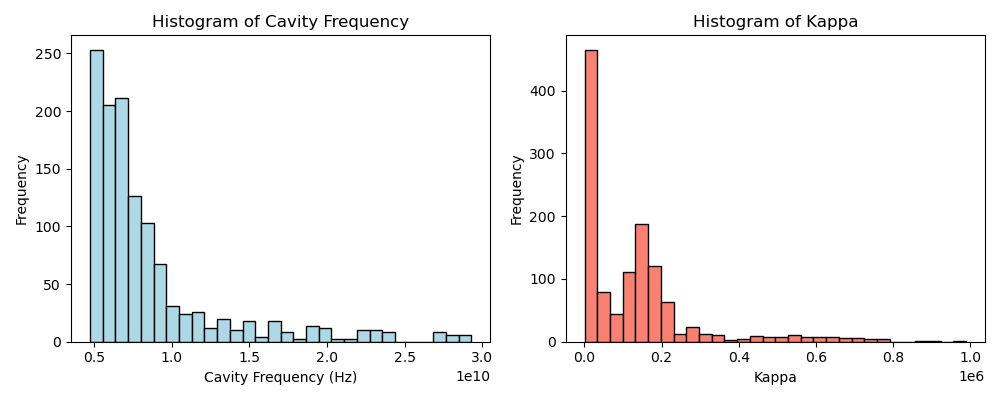

In [22]:
plt.figure(figsize=(10, 4))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist(X['cavity_frequency'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist(X['kappa'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
#plt.show()

In [23]:
plt.savefig('plots/unscaled_X_data.png')
plt.close()

Text(0, 0.5, 'Kappa')

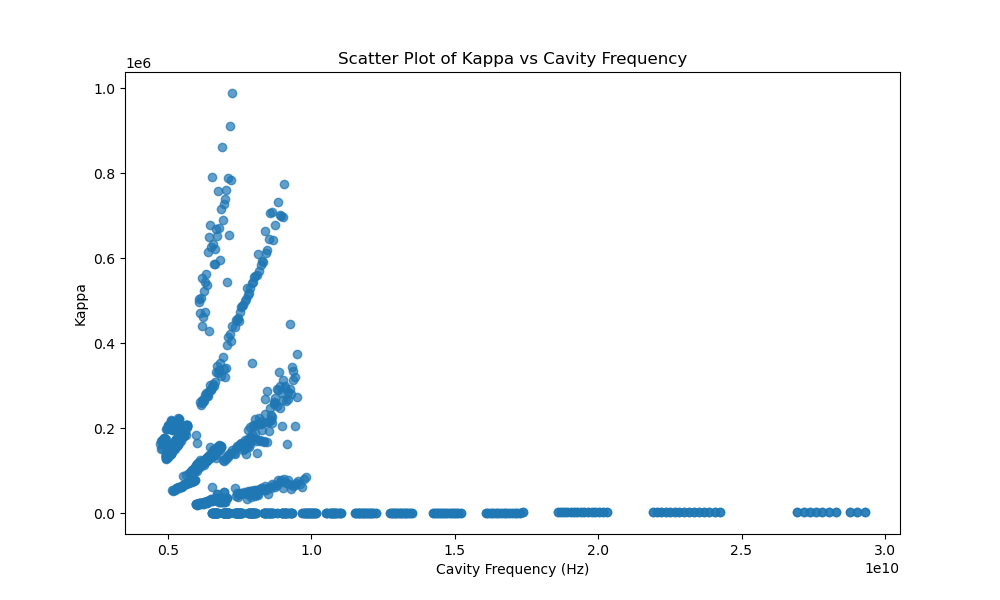

In [24]:
kappa_values = X['kappa']
cavity_frequency_values = X['cavity_frequency']

plt.figure(figsize=(10, 6))
plt.scatter(cavity_frequency_values, kappa_values, alpha=0.7)
plt.title('Scatter Plot of Kappa vs Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Kappa')
#plt.grid(True)
#plt.show()

### Y data

In [25]:
plt.close()
i=0
for y_value__encoding_format in y_value__encoding_formats:
    num_cols = len(y_value__encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_value__encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_value__encoding_format[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_value__data_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1
plt.close()
i=0
for y_exists__encoding_format in y_exists__encoding_formats:
    num_cols = len(y_exists__encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 6)) #Reduced figure size
    
    for n, col in enumerate(y_exists__encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_exists__encoding_format[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_exists__data_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1

/tmp/ipykernel_6259/682791019.py:43: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


In [26]:
plt.close()

### X vs Y correlation plots

In [27]:
i=0
for y_exists__encoding_format in y_exists__encoding_formats:
    num_cols = len(y_exists__encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) 
    for n, col in enumerate(y_exists__encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.scatter(y_exists__encoding_format[col], kappa_values, alpha=0.7) 
            plt.ylabel('Kappa', fontsize=8) 
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_exists__vs_kappa_correlation_{y_encoding_format_names[i]}_encoding.png')
    i+=1
plt.close()
i=0
for y_value__encoding_format in y_value__encoding_formats:
    num_cols = len(y_value__encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) 
    for n, col in enumerate(y_value__encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.scatter(y_value__encoding_format[col], kappa_values, alpha=0.7) 
            plt.ylabel('Kappa', fontsize=8) 
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_value__vs_kappa_correlation_{y_encoding_format_names[i]}_encoding.png')
    i+=1

In [28]:
plt.close()
i=0
for y_value__encoding_format in y_value__encoding_formats:
    num_cols = len(y_value__encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) 
    for n, col in enumerate(y_value__encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.scatter(y_value__encoding_format[col], cavity_frequency_values, alpha=0.7) 
            plt.ylabel('Cavity Frequency', fontsize=8) 
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_value__vs_cavity_freq_correlation_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1
    
plt.close()
i=0
for y_exists__encoding_format in y_exists__encoding_formats:
    num_cols = len(y_exists__encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) 
    for n, col in enumerate(y_exists__encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.scatter(y_exists__encoding_format[col], cavity_frequency_values, alpha=0.7) 
            plt.ylabel('Cavity Frequency', fontsize=8) 
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_vs_cavity_freq_correlation_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1

In [29]:
plt.close()

## Augment 

### Scale X

Scale kappa and frequency to be between 0 and 1

In [30]:
X_scaled = X.copy()
for col in X_scaled.columns:
    scaler = MinMaxScaler()
    X_scaled[col] = scaler.fit_transform(X_scaled[[col]]) #only fit to this column
    joblib.dump(scaler, f'scalers/scaler_X_{col}.save') #save for later

In [31]:
# Check the scaling
display(X_scaled)

,cavity_frequency,kappa
0,0.025177,0.162590
1,0.149175,0.271163
2,0.161210,0.258476
3,0.076598,0.030401
4,0.132385,0.210345
...,...,...
1211,0.112145,0.046129
1212,0.110628,0.038877
1213,0.109137,0.046829
1214,0.107628,0.041597


### Scale y

In [34]:
y_exists__scaled_encoding_formats = []

i=0
for y_exists__encoding_format in y_exists__encoding_formats:
    y_exists__scaled = y_exists__encoding_format.copy()
    for col in y_exists__scaled.columns:
        scaler = MinMaxScaler()
        y_exists__scaled[col] = scaler.fit_transform(y_exists__scaled[[col]]) #only fit to this column
        joblib.dump(scaler, f'scalers/scaler_y_exists__{col}_{y_encoding_format_names[i]}_encoding.save') #save for later
    y_exists__scaled_encoding_formats.append(y_exists__scaled)
    i+=1

y_value__scaled_encoding_formats = []

i=0
for y_value__encoding_format in y_value__encoding_formats:
    y_value__scaled = y_value__encoding_format.copy()
    for col in y_value__scaled.columns:
        scaler = MinMaxScaler()
        y_value__scaled[col] = scaler.fit_transform(y_value__scaled[[col]]) #only fit to this column
        joblib.dump(scaler, f'scalers/scaler_y_value__{col}_{y_encoding_format_names[i]}_encoding.save') #save for later
    y_value__scaled_encoding_formats.append(y_value__scaled)
    i+=1

### Plot Scaled Data

### X

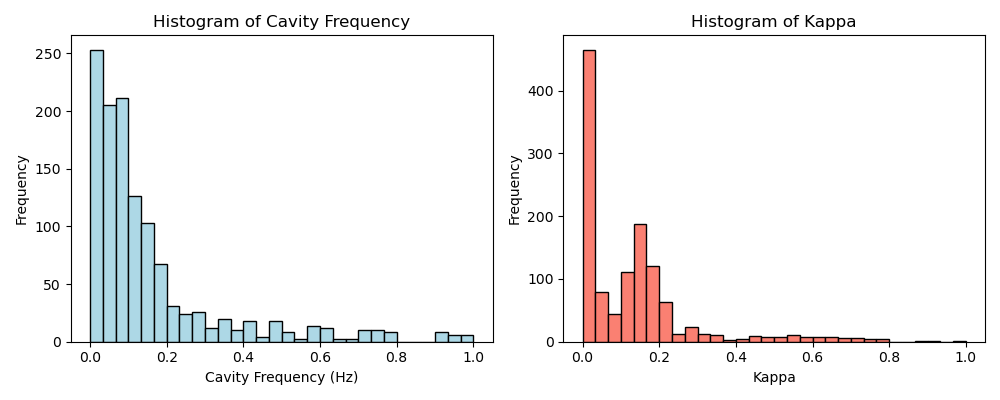

In [35]:
plt.figure(figsize=(10, 4))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist(X_scaled['cavity_frequency'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist(X_scaled['kappa'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
plt.savefig('plots/scaled_X_data.png')
plt.close()

In [37]:
plt.savefig('plots/scaled_X_data.png')
plt.close()

### Y

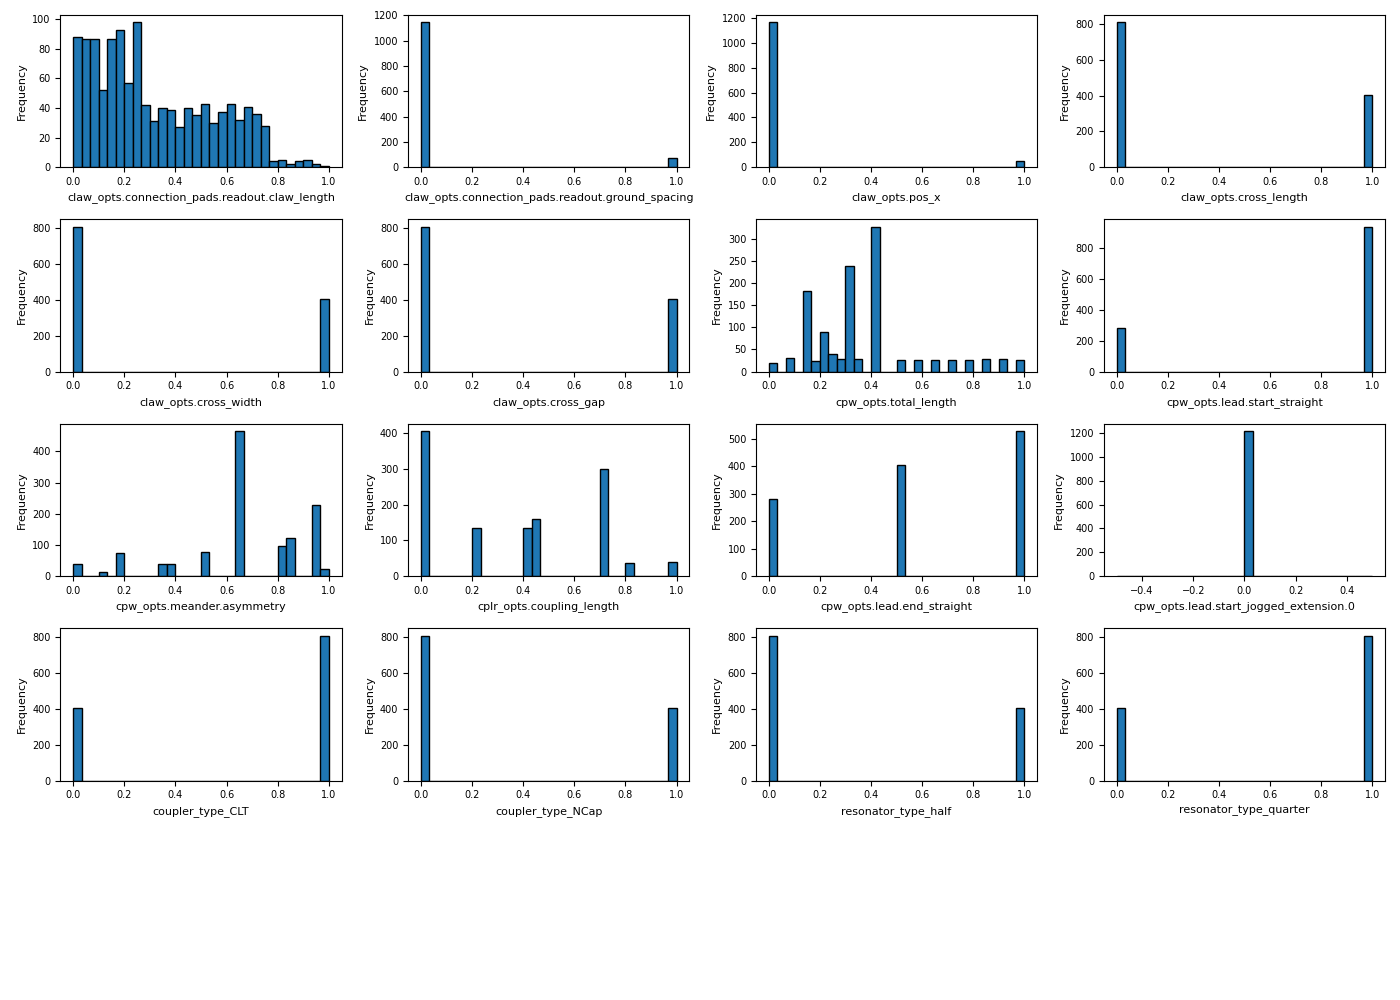

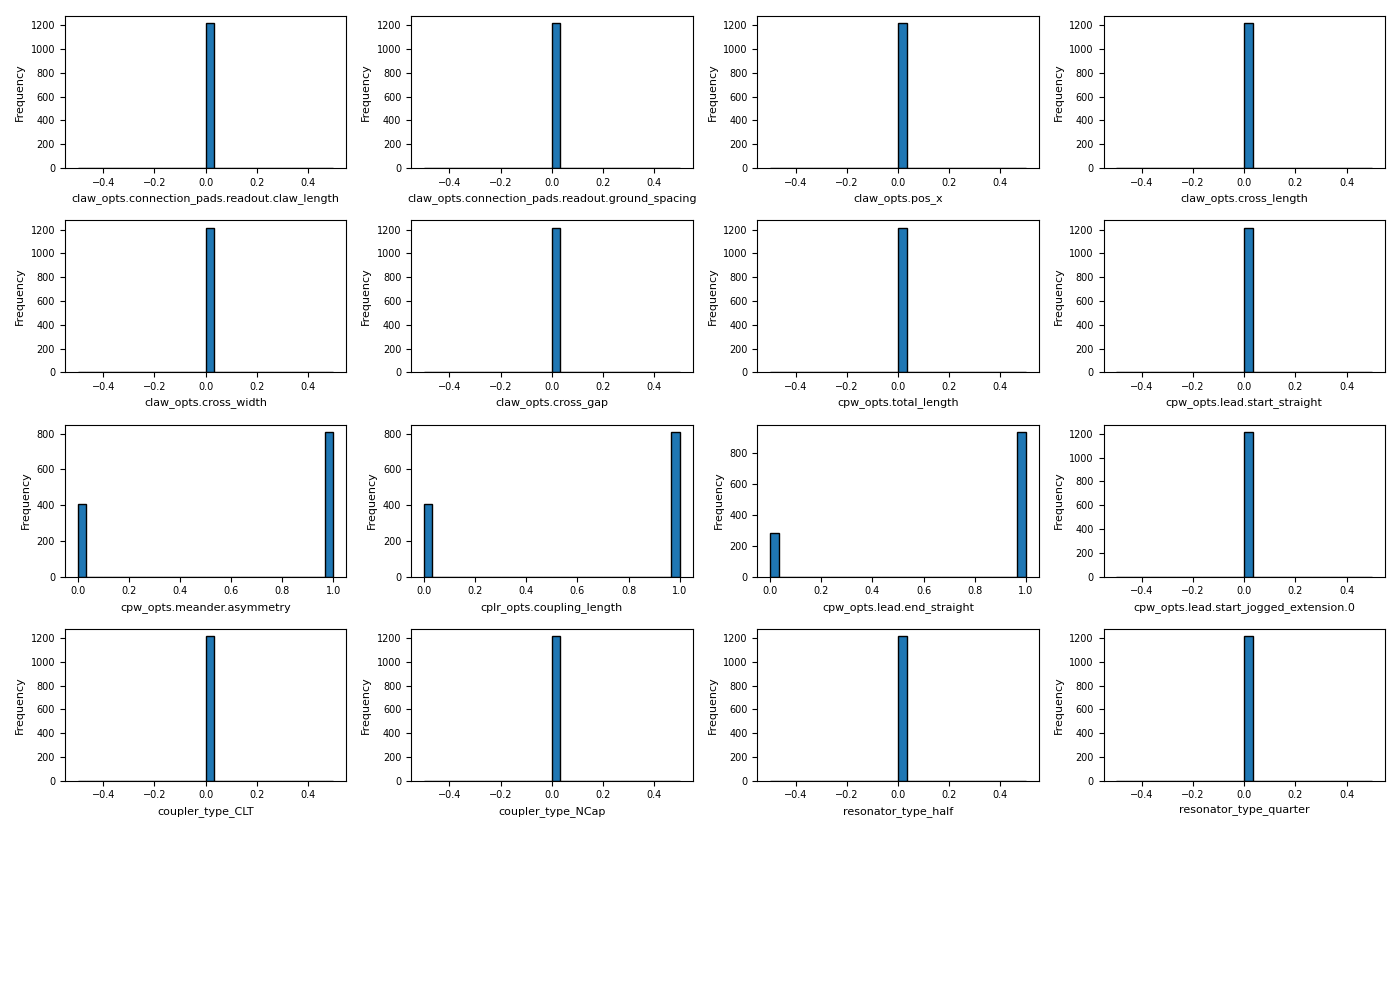

In [38]:
i=0
for y_value__scaled in y_value__scaled_encoding_formats:

    num_cols = len(y_value__scaled.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_value__scaled.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_value__scaled[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/scaled_y_value__data_{y_encoding_format_names[i]}_encoding.png')
    plt.show()
    i+=1

i=0
for y_exists__scaled in y_exists__scaled_encoding_formats:

    num_cols = len(y_exists__scaled.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_exists__scaled.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_exists__scaled[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/scaled_y_exists__data_{y_encoding_format_names[i]}_encoding.png')
    plt.show()
    i+=1

In [39]:
plt.close()

### Unscale to make sure you can recreate original values with saved scaler

### Unscale X

In [40]:
X_orig = X_scaled.copy()
for col in X_scaled.columns:
    scaler = joblib.load(f'scalers/scaler_X_{col}.save')
    X_orig[col] = scaler.inverse_transform(X_scaled[[col]]) 

display(X_orig)

,cavity_frequency,kappa
0,5.353550e+09,161106.598429
1,8.399241e+09,268412.116632
2,8.694845e+09,255873.654612
3,6.616574e+09,30459.761161
4,7.986835e+09,208304.221064
...,...,...
1211,7.489689e+09,46004.713078
1212,7.452442e+09,38837.211205
1213,7.415826e+09,46696.417529
1214,7.378752e+09,41526.048615


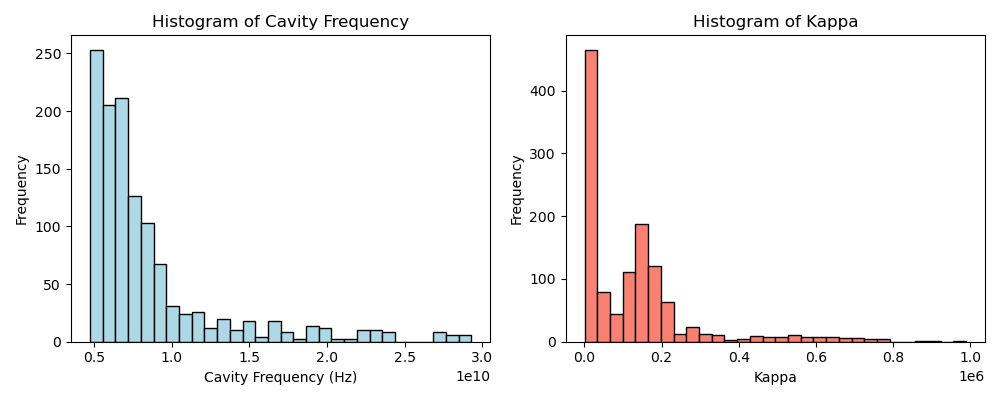

In [41]:
#plot again to see if you get same histgrams as pre-scaling
plt.figure(figsize=(10, 4))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist(X_orig['cavity_frequency'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist(X_orig['kappa'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Unscale Y

In [44]:
y_orig_exists__encoding_formats = []

i=0
for y_exists__scaled in y_exists__scaled_encoding_formats:
    y_orig = y_exists__scaled.copy()
    for col in y_exists__scaled.columns:
        scaler = joblib.load(f'scalers/scaler_y_exists__{col}_{y_encoding_format_names[i]}_encoding.save')
        y_orig[col] = scaler.inverse_transform(y_exists__scaled[[col]])
    y_orig_exists__encoding_formats.append(y_orig)
    print('Encoding Type: ', y_encoding_format_names[i])
    display(y_orig)
    print('\n')
    i+=1

y_orig_value__encoding_formats = []

i=0
for y_value__scaled in y_value__scaled_encoding_formats:
    y_orig = y_value__scaled.copy()
    for col in y_value__scaled.columns:
        scaler = joblib.load(f'scalers/scaler_y_value__{col}_{y_encoding_format_names[i]}_encoding.save')
        y_orig[col] = scaler.inverse_transform(y_value__scaled[[col]])
    y_orig_value__encoding_formats.append(y_orig)
    print('Encoding Type: ', y_encoding_format_names[i])
    display(y_orig)
    print('\n')
    i+=1

Encoding Type:  one_hot


,design_options.claw_opts.connection_pads.readout.claw_length,design_options.claw_opts.connection_pads.readout.ground_spacing,design_options.claw_opts.pos_x,design_options.claw_opts.cross_length,design_options.claw_opts.cross_width,design_options.claw_opts.cross_gap,design_options.cpw_opts.total_length,design_options.cpw_opts.lead.start_straight,design_options.cpw_opts.meander.asymmetry,design_options.cplr_opts.coupling_length,design_options.cpw_opts.lead.end_straight,design_options.cpw_opts.lead.start_jogged_extension.0,coupler_type_CLT,coupler_type_NCap,resonator_type_half,resonator_type_quarter
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1212,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1213,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1214,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0




Encoding Type:  one_hot


,design_options.claw_opts.connection_pads.readout.claw_length,design_options.claw_opts.connection_pads.readout.ground_spacing,design_options.claw_opts.pos_x,design_options.claw_opts.cross_length,design_options.claw_opts.cross_width,design_options.claw_opts.cross_gap,design_options.cpw_opts.total_length,design_options.cpw_opts.lead.start_straight,design_options.cpw_opts.meander.asymmetry,design_options.cplr_opts.coupling_length,design_options.cpw_opts.lead.end_straight,design_options.cpw_opts.lead.start_jogged_extension.0,coupler_type_CLT,coupler_type_NCap,resonator_type_half,resonator_type_quarter
0,0.00022,0.000004,-0.0015,0.0,0.0,0.0,0.0047,0.00005,-0.000175,0.00035,0.0000,0.0,1.0,0.0,0.0,1.0
1,0.00027,0.000004,-0.0015,0.0,0.0,0.0,0.0027,0.00005,-0.000100,0.00020,0.0000,0.0,1.0,0.0,0.0,1.0
2,0.00021,0.000004,-0.0015,0.0,0.0,0.0,0.0027,0.00010,0.000067,0.00020,0.0001,0.0,1.0,0.0,0.0,1.0
3,0.00021,0.000004,-0.0015,0.0,0.0,0.0,0.0039,0.00005,-0.000050,0.00010,0.0000,0.0,1.0,0.0,0.0,1.0
4,0.00036,0.000004,-0.0015,0.0,0.0,0.0,0.0027,0.00010,0.000067,0.00020,0.0001,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,0.00038,0.000010,-0.0015,0.0,0.0,0.0,0.0030,0.00010,0.000000,0.00010,0.0001,0.0,1.0,0.0,0.0,1.0
1212,0.00039,0.000010,-0.0015,0.0,0.0,0.0,0.0030,0.00010,0.000000,0.00010,0.0001,0.0,1.0,0.0,0.0,1.0
1213,0.00040,0.000010,-0.0015,0.0,0.0,0.0,0.0030,0.00010,0.000000,0.00010,0.0001,0.0,1.0,0.0,0.0,1.0
1214,0.00041,0.000010,-0.0015,0.0,0.0,0.0,0.0030,0.00010,0.000000,0.00010,0.0001,0.0,1.0,0.0,0.0,1.0


/tmp/ipykernel_6259/131676404.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


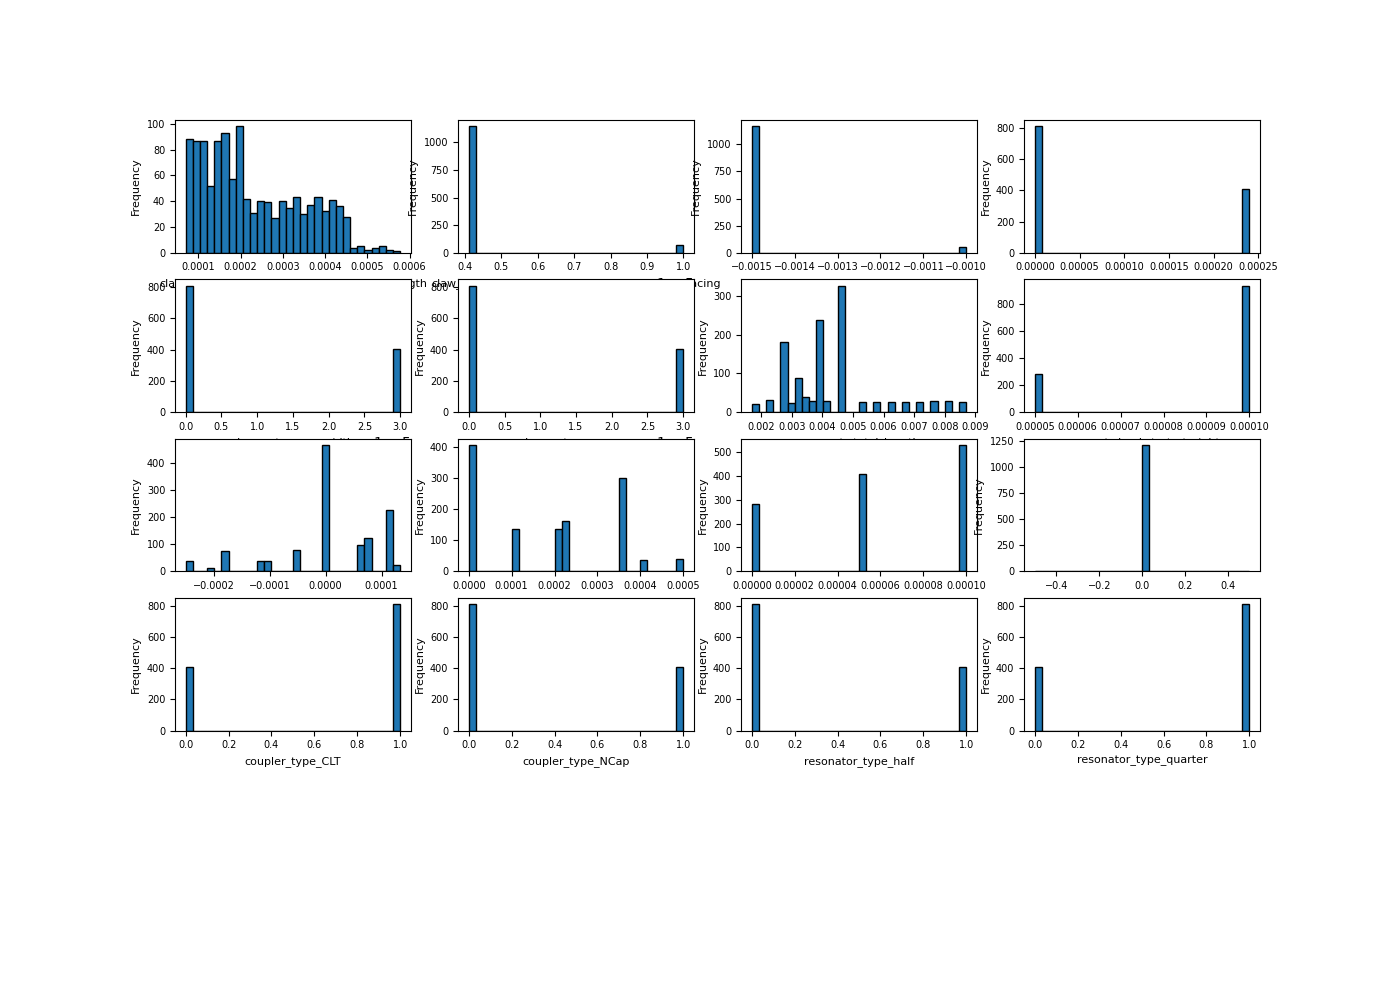

/tmp/ipykernel_6259/131676404.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


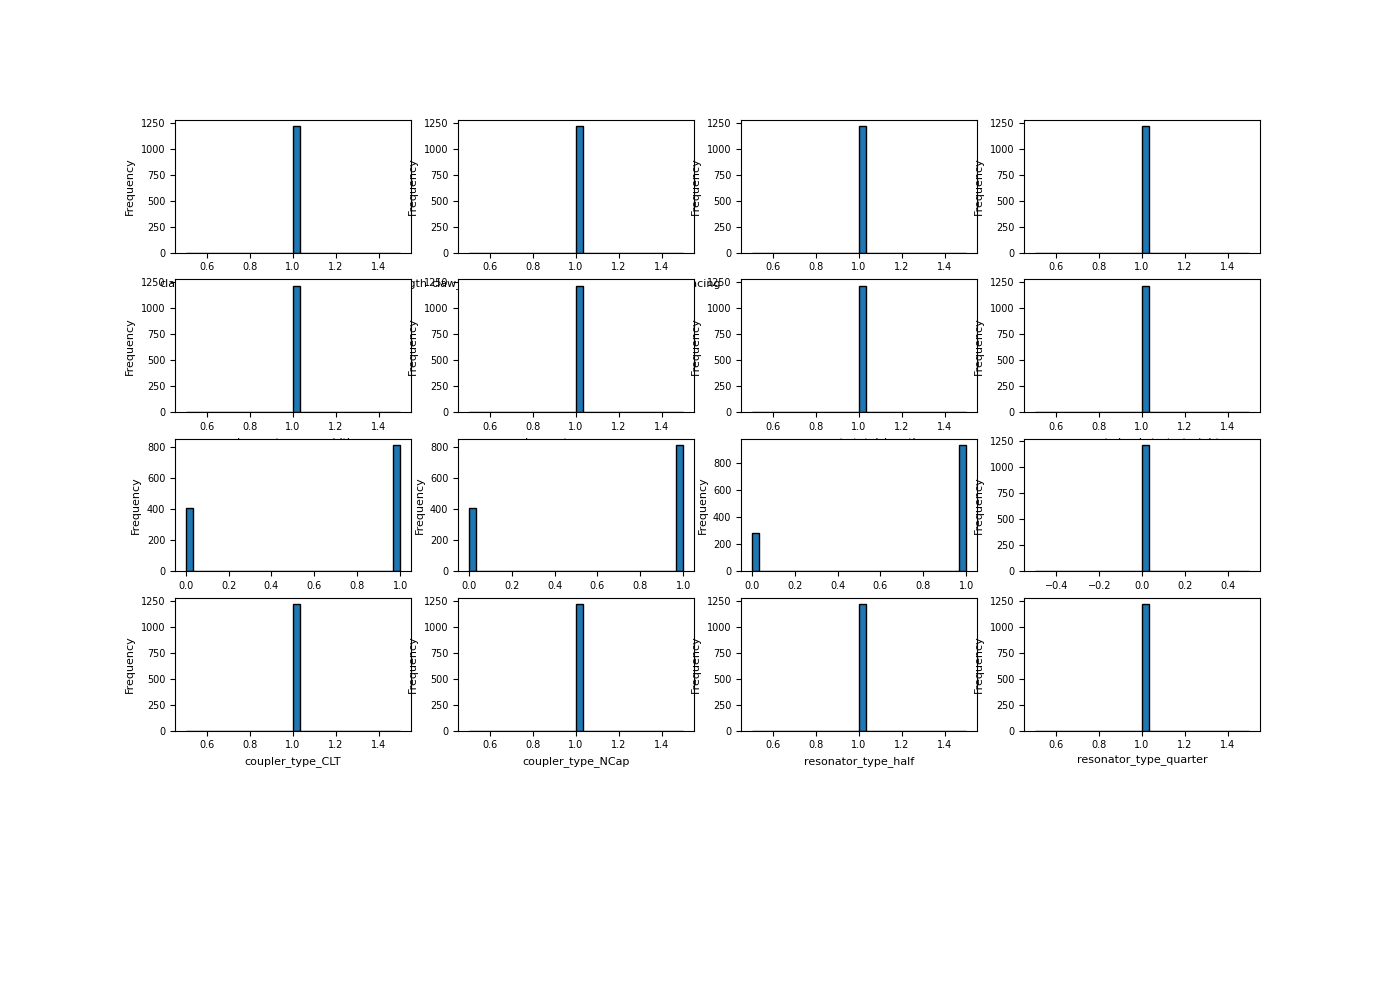

In [45]:
i=0
for y_orig in y_orig_value__encoding_formats:
    num_cols = len(y_orig.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for i, col in enumerate(y_orig.columns):
        try:
            plt.subplot(num_rows, 4, i + 1)
            plt.hist(y_orig[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.show()
    i+=1

i=0
for y_orig in y_orig_exists__encoding_formats:
    num_cols = len(y_orig.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for i, col in enumerate(y_orig.columns):
        try:
            plt.subplot(num_rows, 4, i + 1)
            plt.hist(y_orig[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.show()
    i+=1

## Split

In [46]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print('Tensorflow ver.', tf.__version__)

2025-12-11 02:45:17.944657: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 02:45:18.855165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow ver. 2.20.0


Dataset split is 70%-30% training-validation and test sets. We use a constant state (seed) for reproducible splits across multiple runs.

In [56]:
# Unscaled data split
if 'one hot' in ENCODING_TYPE:
    # First: train vs (val+test)
    X_train, X_val_test, y_value_train_one_hot_encoding, y_value_val_test_one_hot_encoding, y_exists_train_one_hot_encoding, y_exists_val_test_one_hot_encoding = train_test_split(X, y_value__encoding_formats[0], y_exists__encoding_formats[0], test_size=0.3, random_state=42, shuffle=True)
    # Then: val vs test
    X_val, X_test, y_value_val_one_hot_encoding, y_value_test_one_hot_encoding, y_exists_val_one_hot_encoding, y_exists_test_one_hot_encoding = train_test_split(X_val_test, y_value_val_test_one_hot_encoding, y_exists_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True)

elif 'Linear' in ENCODING_TYPE:
    X_train, X_val_test, y_value_train_linear_encoding, y_value_val_test_linear_encoding, y_exists_train_linear_encoding, y_exists_val_test_linear_encoding = train_test_split(X, y_value__encoding_formats[1], y_exists__encoding_formats[1], test_size=0.3, random_state=42, shuffle=True)
    X_val, X_test, y_value_val_linear_encoding, y_value_test_linear_encoding, y_exists_val_linear_encoding, y_exists_test_linear_encoding = train_test_split(X_val_test, y_value_val_test_linear_encoding, y_exists_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True)

elif 'Try Both' in ENCODING_TYPE:
    # One-hot branch (index 0)
    X_train_one_hot_encoding, X_val_test_one_hot_encoding, y_value_train_one_hot_encoding, y_value_val_test_one_hot_encoding, y_exists_train_one_hot_encoding, y_exists_val_test_one_hot_encoding = train_test_split(X, y_value__encoding_formats[0], y_exists__encoding_formats[0], test_size=0.3, random_state=42, shuffle=True)
    X_val_one_hot_encoding, X_test_one_hot_encoding, y_value_val_one_hot_encoding, y_value_test_one_hot_encoding, y_exists_val_one_hot_encoding, y_exists_test_one_hot_encoding = train_test_split(X_val_test_one_hot_encoding, y_value_val_test_one_hot_encoding, y_exists_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True)

    # Linear branch (index 1)
    X_train_linear_encoding, X_val_test_linear_encoding, y_value_train_linear_encoding, y_value_val_test_linear_encoding, y_exists_train_linear_encoding, y_exists_val_test_linear_encoding = train_test_split(X, y_value__encoding_formats[1], y_exists__encoding_formats[1], test_size=0.3, random_state=42, shuffle=True)
    X_val_linear_encoding, X_test_linear_encoding, y_value_val_linear_encoding, y_value_test_linear_encoding, y_exists_val_linear_encoding, y_exists_test_linear_encoding = train_test_split(X_val_test_linear_encoding, y_value_val_test_linear_encoding, y_exists_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True)

# Scaled data split
if 'one hot' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_value_train_scaled_one_hot_encoding, y_value_val_test_scaled_one_hot_encoding, y_exists_train_scaled_one_hot_encoding, y_exists_val_test_scaled_one_hot_encoding = train_test_split(X_scaled, y_value__scaled_encoding_formats[0], y_exists__scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True)
    X_val_scaled, X_test_scaled, y_value_val_scaled_one_hot_encoding, y_value_test_scaled_one_hot_encoding, y_exists_val_scaled_one_hot_encoding, y_exists_test_scaled_one_hot_encoding = train_test_split(X_val_test_scaled, y_value_val_test_scaled_one_hot_encoding, y_exists_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True)

elif 'Linear' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_value_train_scaled_linear_encoding, y_value_val_test_scaled_linear_encoding, y_exists_train_scaled_linear_encoding, y_exists_val_test_scaled_linear_encoding = train_test_split(X_scaled, y_value__scaled_encoding_formats[1], y_exists__scaled_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True)
    X_val_scaled, X_test_scaled, y_value_val_scaled_linear_encoding, y_value_test_scaled_linear_encoding, y_exists_val_scaled_linear_encoding, y_exists_test_scaled_linear_encoding = train_test_split(X_val_test_scaled, y_value_val_test_scaled_linear_encoding, y_exists_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True)

elif 'Try Both' in ENCODING_TYPE:
    # One-hot scaled
    X_train_scaled_one_hot_encoding, X_val_test_scaled_one_hot_encoding, y_value_train_scaled_one_hot_encoding, y_value_val_test_scaled_one_hot_encoding, y_exists_train_scaled_one_hot_encoding, y_exists_val_test_scaled_one_hot_encoding = train_test_split(X_scaled, y_value__scaled_encoding_formats[0], y_exists__scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True)
    X_val_scaled_one_hot_encoding, X_test_scaled_one_hot_encoding, y_value_val_scaled_one_hot_encoding, y_value_test_scaled_one_hot_encoding, y_exists_val_scaled_one_hot_encoding, y_exists_test_scaled_one_hot_encoding = train_test_split(X_val_test_scaled_one_hot_encoding, y_value_val_test_scaled_one_hot_encoding, y_exists_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True)

    # Linear scaled
    X_train_scaled_linear_encoding, X_val_test_scaled_linear_encoding, y_value_train_scaled_linear_encoding, y_value_val_test_scaled_linear_encoding, y_exists_train_scaled_linear_encoding, y_exists_val_test_scaled_linear_encoding = train_test_split(X_scaled, y_value__scaled_encoding_formats[1], y_exists__scaled_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True)
    X_val_scaled_linear_encoding, X_test_scaled_linear_encoding, y_value_val_scaled_linear_encoding, y_value_test_scaled_linear_encoding, y_exists_val_scaled_linear_encoding, y_exists_test_scaled_linear_encoding = train_test_split(X_val_test_scaled_linear_encoding, y_value_val_test_scaled_linear_encoding, y_exists_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True)

In [48]:
# unscaled
if 'one hot' in ENCODING_TYPE:
    total = y_value_train_one_hot_encoding.shape[0] + y_value_test_one_hot_encoding.shape[0] + y_value_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_value_train_one_hot_encoding.shape, (y_value_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_value_val_one_hot_encoding.shape, (y_value_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_value_test_one_hot_encoding.shape, (y_value_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

elif 'Linear' in ENCODING_TYPE:
    total = y_value_train_linear_encoding.shape[0] + y_value_test_linear_encoding.shape[0] + y_value_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_value_train_linear_encoding.shape, (y_value_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_value_val_linear_encoding.shape, (y_value_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_value_test_linear_encoding.shape, (y_value_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

elif 'Try Both' in ENCODING_TYPE:
    total = y_value_train_one_hot_encoding.shape[0] + y_value_test_one_hot_encoding.shape[0] + y_value_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_value_train_one_hot_encoding.shape, (y_value_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_value_val_one_hot_encoding.shape, (y_value_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_value_test_one_hot_encoding.shape, (y_value_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_value_train_linear_encoding.shape[0] + y_value_test_linear_encoding.shape[0] + y_value_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_value_train_linear_encoding.shape, (y_value_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_value_val_linear_encoding.shape, (y_value_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_value_test_linear_encoding.shape, (y_value_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')


---------------------------------------
Train one-hot encoding set shape: (851, 16), 69.98%
Validation one-hot encoding set shape: (182, 16), 14.97%
Test set shape:                 (183, 16), 15.05%
---------------------------------------


In [49]:
# scaled
if 'one hot' in ENCODING_TYPE:
    total = y_value_train_scaled_one_hot_encoding.shape[0] + y_value_test_scaled_one_hot_encoding.shape[0] + y_value_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_value_train_scaled_one_hot_encoding.shape, (y_value_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_value_val_scaled_one_hot_encoding.shape, (y_value_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_value_test_scaled_one_hot_encoding.shape, (y_value_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

elif 'Linear' in ENCODING_TYPE:
    total = y_value_train_scaled_linear_encoding.shape[0] + y_value_test_scaled_linear_encoding.shape[0] + y_value_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_value_train_scaled_linear_encoding.shape, (y_value_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_value_val_scaled_linear_encoding.shape, (y_value_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_value_test_scaled_linear_encoding.shape, (y_value_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

elif 'Try Both' in ENCODING_TYPE:
    total = y_value_train_scaled_one_hot_encoding.shape[0] + y_value_test_scaled_one_hot_encoding.shape[0] + y_value_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_value_train_scaled_one_hot_encoding.shape, (y_value_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_value_val_scaled_one_hot_encoding.shape, (y_value_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_value_test_scaled_one_hot_encoding.shape, (y_value_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_value_train_scaled_linear_encoding.shape[0] + y_value_test_scaled_linear_encoding.shape[0] + y_value_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_value_train_scaled_linear_encoding.shape, (y_value_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_value_val_scaled_linear_encoding.shape, (y_value_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_value_test_scaled_linear_encoding.shape, (y_value_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')


---------------------------------------
Train one-hot encoding set shape: (851, 16), 69.98%
Validation one-hot encoding set shape: (182, 16), 14.97%
Test set shape:                 (183, 16), 15.05%
---------------------------------------


In [50]:
if 'Try Both' not in ENCODING_TYPE:
    display(X_train_scaled) #can check this in next script as well after loading to make sure it matches
    display(X_val_scaled)
else:
    display(X_train_scaled_one_hot_encoding) 
    display(X_val_scaled_one_hot_encoding)
    
    display(X_train_scaled_linear_encoding) 
    display(X_val_scaled_linear_encoding)

,cavity_frequency,kappa
630,0.335150,0.000787
215,0.018092,0.152657
1052,0.010328,0.147638
27,0.024358,0.159239
1172,0.121391,0.163866
...,...,...
1044,0.016079,0.155945
1095,0.036666,0.206972
1130,0.057548,0.256099
860,0.577813,0.001341


,cavity_frequency,kappa
666,0.108288,0.000269
876,0.390310,0.000913
344,0.198377,0.069497
857,0.075206,0.000193
796,0.131031,0.000321
...,...,...
1202,0.130166,0.051869
628,0.479914,0.001118
561,0.347187,0.000814
1152,0.010721,0.208710


### Save

Save the split data set for future reference

In [51]:
!rm -f $DATA_DIR/npy/*npy

In [52]:
# unscaled
if 'one hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), X_test)

    np.save('{}/npy/y_value_train_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_value_train_one_hot_encoding))
    np.save('{}/npy/y_value_val_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_value_val_one_hot_encoding))
    np.save('{}/npy/y_value_test_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_value_test_one_hot_encoding))

    np.save('{}/npy/y_exists_train_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_train_one_hot_encoding))
    np.save('{}/npy/y_exists_val_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_val_one_hot_encoding))
    np.save('{}/npy/y_exists_test_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_test_one_hot_encoding))

elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), X_test)

    np.save('{}/npy/y_value_train_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_value_train_linear_encoding))
    np.save('{}/npy/y_value_val_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_value_val_linear_encoding))
    np.save('{}/npy/y_value_test_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_value_test_linear_encoding))

    np.save('{}/npy/y_exists_train_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_train_linear_encoding))
    np.save('{}/npy/y_exists_val_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_val_linear_encoding))
    np.save('{}/npy/y_exists_test_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_test_linear_encoding))

elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), X_train_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), X_val_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), X_test_one_hot_encoding)

    np.save('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), X_train_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), X_val_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), X_test_linear_encoding)

    np.save('{}/npy/y_value_train_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_value_train_one_hot_encoding))
    np.save('{}/npy/y_value_val_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_value_val_one_hot_encoding))
    np.save('{}/npy/y_value_test_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_value_test_one_hot_encoding))

    np.save('{}/npy/y_exists_train_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_train_one_hot_encoding))
    np.save('{}/npy/y_exists_val_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_val_one_hot_encoding))
    np.save('{}/npy/y_exists_test_one_hot_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_test_one_hot_encoding))

    np.save('{}/npy/y_value_train_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_value_train_linear_encoding))
    np.save('{}/npy/y_value_val_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_value_val_linear_encoding))
    np.save('{}/npy/y_value_test_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_value_test_linear_encoding))

    np.save('{}/npy/y_exists_train_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_train_linear_encoding))
    np.save('{}/npy/y_exists_val_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_val_linear_encoding))
    np.save('{}/npy/y_exists_test_linear_encoding.npy'.format(DATA_DIR), np.asarray(y_exists_test_linear_encoding))

print('Data saved in: {}/npy'.format(DATA_DIR))


Data saved in: data/npy


In [53]:
# scaled
if 'one hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled)

    np.save('{}/npy/y_value_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_train_scaled_one_hot_encoding))
    np.save('{}/npy/y_value_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_val_scaled_one_hot_encoding))
    np.save('{}/npy/y_value_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_test_scaled_one_hot_encoding))

    np.save('{}/npy/y_exists_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_train_scaled_one_hot_encoding))
    np.save('{}/npy/y_exists_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_val_scaled_one_hot_encoding))
    np.save('{}/npy/y_exists_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_test_scaled_one_hot_encoding))

elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled)

    np.save('{}/npy/y_value_train_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_train_scaled_linear_encoding))
    np.save('{}/npy/y_value_val_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_val_scaled_linear_encoding))
    np.save('{}/npy/y_value_test_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_test_scaled_linear_encoding))

    np.save('{}/npy/y_exists_train_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_train_scaled_linear_encoding))
    np.save('{}/npy/y_exists_val_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_val_scaled_linear_encoding))
    np.save('{}/npy/y_exists_test_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_test_scaled_linear_encoding))

elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_one_hot_encoding)

    np.save('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_linear_encoding)

    np.save('{}/npy/y_value_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_train_scaled_one_hot_encoding))
    np.save('{}/npy/y_value_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_val_scaled_one_hot_encoding))
    np.save('{}/npy/y_value_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_test_scaled_one_hot_encoding))

    np.save('{}/npy/y_exists_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_train_scaled_one_hot_encoding))
    np.save('{}/npy/y_exists_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_val_scaled_one_hot_encoding))
    np.save('{}/npy/y_exists_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_test_scaled_one_hot_encoding))

    np.save('{}/npy/y_value_train_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_train_scaled_linear_encoding))
    np.save('{}/npy/y_value_val_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_val_scaled_linear_encoding))
    np.save('{}/npy/y_value_test_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_value_test_scaled_linear_encoding))

    np.save('{}/npy/y_exists_train_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_train_scaled_linear_encoding))
    np.save('{}/npy/y_exists_val_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_val_scaled_linear_encoding))
    np.save('{}/npy/y_exists_test_linear_encoding_augmented.npy'.format(DATA_DIR), np.asarray(y_exists_test_scaled_linear_encoding))

print('Data saved in: {}/npy'.format(DATA_DIR))


Data saved in: data/npy


In [54]:
!ls $DATA_DIR/npy/*npy

data/npy/x_test_one_hot_encoding_augmented.npy
data/npy/x_test_one_hot_encoding.npy
data/npy/x_train_one_hot_encoding_augmented.npy
data/npy/x_train_one_hot_encoding.npy
data/npy/x_val_one_hot_encoding_augmented.npy
data/npy/x_val_one_hot_encoding.npy
data/npy/y_exists_test_one_hot_encoding_augmented.npy
data/npy/y_exists_test_one_hot_encoding.npy
data/npy/y_exists_train_one_hot_encoding_augmented.npy
data/npy/y_exists_train_one_hot_encoding.npy
data/npy/y_exists_val_one_hot_encoding_augmented.npy
data/npy/y_exists_val_one_hot_encoding.npy
data/npy/y_value_test_one_hot_encoding_augmented.npy
data/npy/y_value_test_one_hot_encoding.npy
data/npy/y_value_train_one_hot_encoding_augmented.npy
data/npy/y_value_train_one_hot_encoding.npy
data/npy/y_value_val_one_hot_encoding_augmented.npy
data/npy/y_value_val_one_hot_encoding.npy


In [55]:
with open('X_names', 'w') as f:
        f.write('\n'.join(X.columns))